In [1]:
# ANALISI SHAP DATASET DI TEST TOTALE, VISUALIZZAZIONE DIVISA PER IMPATTO SU CLASSE 0 E 1


In [1]:
import torch
from transformers import AutoTokenizer

import shap
import nltk
import pickle
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

nltk.download("punkt")
from nltk.tokenize import sent_tokenize, word_tokenize

# from error_analysis_TRC import load_local_model
from TRC.utils import create_token_dict, get_top_n, load_local_TRC_model


from better_profanity import profanity
from copy import deepcopy
from ast import literal_eval

/home/cc/venv/rora_venv/lib/python3.8/site-packages/shap/utils/_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
/home/cc/venv/rora_venv/lib/python3.8/site-packages/shap/utils/_clustering.py:54: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def delta_minimization_order(all_masks,

In [2]:
ASSIGN_WEIGHT = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = "cpu"
model_name = 'roberta-large'

# model_path = '/home/agensale/rora_tesi_new/log/log_EFRA/news/roberta-large/from_finetuned/10_epoch/SampleAgroknow/True_weight/42_seed/saved-model/pytorch_model.bin'
# config_path = '/home/agensale/rora_tesi_new/log/log_EFRA/news/roberta-large/from_finetuned/10_epoch/SampleAgroknow/True_weight/42_seed/saved-model/config.json'

model_path = '/home/cc/rob-large/pytorch_model.bin'
config_path = '/home/cc/rob-large/config.json'

In [3]:
tokenizer = AutoTokenizer.from_pretrained(model_name, normalization = True)
model = load_local_TRC_model(model_path, config_path, device, model_name)
model = model.to(device)

Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.dense.bias', 'roberta.pooler.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [4]:
# come input prende una lista di tweet
def f(x):
    # x = [tweet_test[0]]
    tv = torch.tensor([tokenizer.encode(v, padding='max_length', max_length=128, truncation=True) for v in x]).to(device)
    # print('tv',tv.shape)
    attention_mask = (tv!=0).type(torch.int64).to(device)
    # print('atte',attention_mask.shape)
    model.eval()
    with torch.no_grad():
        outputs = model(tv, attention_mask, class_weight=None)
    # print(outputs)

    return outputs['logits']

In [5]:
explainer = shap.Explainer(f, masker = tokenizer)
explainer

In [139]:
news_corrette = pd.read_csv('/home/cc/rora_tesi_new/log/log_EFRA/news/roberta-large/from_finetuned/10_epoch/SampleAgroknow/True_weight/42_seed/news_corrette.csv', index_col = 0, converters={'News tok':literal_eval})
news_errate = pd.read_csv('/home/cc/rora_tesi_new/log/log_EFRA/news/roberta-large/from_finetuned/10_epoch/SampleAgroknow/True_weight/42_seed/news_errate.csv', index_col = 0, converters={'News tok':literal_eval})

In [140]:
news_total = pd.concat([news_corrette, news_errate])

In [141]:
def flatten_lists(row):
    # Utilizziamo una list comprehension per appiattire le liste di liste mantenendo le stringhe intatte
    return [item for sublist in row for item in sublist]

# Applica la funzione a ogni riga del DataFrame
news_total['lista_piatta'] = news_total['News tok'].apply(flatten_lists)

In [142]:
news_total = news_total[news_total['lista_piatta'].apply(lambda x: len(x) <= 512)]

In [143]:
news_0 = news_total[news_total['True label'] == 0]
news_1 = news_total[news_total['True label'] == 1]

In [144]:
len(news_0) + len(news_1) == len(news_total)

True

In [145]:
news_0 = news_0.sample(n=500, random_state=42, ignore_index= True)
news_1 = news_1.sample(n=500, random_state=42, ignore_index=True)

In [146]:
news_total = pd.concat([news_0, news_1], ignore_index=True)
len(news_total)

1000

In [147]:
news_total = news_total.sample(frac=1).reset_index(drop=True)

In [148]:
# news_total = news_total.sample(n=500, random_state=42, ignore_index= True)

In [149]:
# news_total.head()

In [150]:
# # Espandi le liste di liste in nuove righe
# news_total = news_total.explode("News tok")

# # Resetta l'indice del DataFrame risultante
# news_total.reset_index(drop=True, inplace=True)


In [151]:
def clean_strings(big_tokens_list):
    tags = ['@USER','USER', 'HTTPURL', 'HTTP', 'URL']
    nltk.download('stopwords')
    profanity.load_censor_words()
    stop_words = set(nltk.corpus.stopwords.words('english'))
    clean_list = []
    for t_list in big_tokens_list:
        tokens = deepcopy(t_list)
        for token, i in zip(t_list, range(len(t_list))):
            tmp = deepcopy(token)
            tmp = tmp.strip()
            tmp = tmp.lower()
            if tmp in string.punctuation or \
            tmp.upper() in tags or \
            tmp == '...' or  tmp == '....' or \
            tmp in stop_words or \
            profanity.contains_profanity(tmp) or \
            len(tmp) < 3:
                tokens.remove(token)
        clean_list.append(' '.join(tokens))
    return clean_list
        

In [152]:
# SHAP FOR ALL DS

In [153]:
# all_tweets = df_total['Tweet'].tolist()
all_tweets_tokens = news_total['lista_piatta'].tolist()
# all_tweets_tokens = news_total['News tok'].tolist()

In [154]:
# all_tweets_tokens

In [155]:
cleaned_all = clean_strings(all_tweets_tokens)
cleaned_all[:5]

[nltk_data] Downloading package stopwords to /home/cc/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['USDA announced new Deputy Secretary Food Safety Sandra Eskin previously served Project Director Food Safety Pew Charitable Trust. Eskin experience strategic public policy issues related consumer protection food safety dietary supplement safety food drug labeling advertising. also served federal government staff attorney legislative representative Consumer Federation America well deputy director Produce Safety Project.“Sandra’s deep experience food safety strengthen USDA’s dedication ensuring safe secure food supply consumers help protect safety federal meat inspectors workers throughout food chain said Agriculture Secretary Tom Vilsack USDA press release.“Eskin USDA particularly challenging time agency. COVID pandemic widened inequities worsened nearly every problem food supply employees meat processing facilities hardest hit workers industry. Even setting pandemic aside USDA much could protect Americans foodborne pathogens dangerous strains Salmonella contaminate poultry. Eskin know

In [22]:
lunghezza_media = sum(len(s) for s in cleaned_all) / len(cleaned_all)

# Stampa il risultato
print("Lunghezza media:", lunghezza_media)

Lunghezza media: 841.244


In [156]:
# CREAZIONE SHAP_VALUES E SALVATAGGIO IN PICKLE


save_path = '/home/cc/rora_tesi_new/log/log_EFRA/news/roberta-large/from_finetuned/10_epoch/SampleAgroknow/True_weight/42_seed/shap/'
shap_values = explainer(cleaned_all)
print(shap_values.shape)
print(shap_values.output_names)
with open(save_path + 'shap_values_all_test.pickle', 'wb') as handle:
    pickle.dump(shap_values, handle, protocol=pickle.HIGHEST_PROTOCOL)

Partition explainer:   3%|▎         | 29/1000 [01:54<1:10:47,  4.37s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:   8%|▊         | 75/1000 [05:13<1:00:51,  3.95s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  12%|█▏        | 116/1000 [08:08<1:05:51,  4.47s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  17%|█▋        | 172/1000 [12:08<59:05,  4.28s/it]  

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  26%|██▌       | 262/1000 [18:20<49:25,  4.02s/it]  

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  33%|███▎      | 334/1000 [23:18<48:15,  4.35s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  47%|████▋     | 473/1000 [33:10<38:18,  4.36s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  58%|█████▊    | 580/1000 [40:42<30:40,  4.38s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  63%|██████▎   | 628/1000 [44:07<27:05,  4.37s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  63%|██████▎   | 631/1000 [44:21<28:12,  4.59s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  69%|██████▊   | 687/1000 [48:13<22:48,  4.37s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  75%|███████▌  | 754/1000 [52:59<18:18,  4.46s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  87%|████████▋ | 870/1000 [1:01:09<07:35,  3.50s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  91%|█████████▏| 913/1000 [1:04:02<06:36,  4.56s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  98%|█████████▊| 979/1000 [1:08:38<01:29,  4.25s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer: 1001it [1:10:10,  4.22s/it]                          


(1000, None, 2)
['Output 0', 'Output 1']


In [157]:
# LETTURA DA FILE PICKLE SHAP_VALUES SALVATI 

save_path = '/home/cc/rora_tesi_new/log/log_EFRA/news/roberta-large/from_finetuned/10_epoch/SampleAgroknow/True_weight/42_seed/shap/'
with open(save_path + 'shap_values_all_test.pickle', 'rb') as handle:
    shap_values_loaded = pickle.load(handle)

In [158]:
def token_dict(shap_values):
    token_dict_pos = {}
    token_dict_neg = {}
    nltk.download('stopwords')
    profanity.load_censor_words()
    stop_words = set(nltk.corpus.stopwords.words('english'))
    val = [shap_values[i] for i in range(len(shap_values))]
    for el in val:
        for i in range(len(el)-1):
            token = el[i].data
            token = token.strip()
            if token not in string.punctuation and token != 'USER' and token != 'HTTPURL' and token != 'HTTP' and token!='URL' and token != '...' and len(token) >= 3:
                shap_val = el[i].values
                # pos = abs(shap_val[0])
                # neg = abs(shap_val[1])
                pos = shap_val[1]
                neg = shap_val[0]
                token = token.lower()
                if token not in stop_words:
                    if not profanity.contains_profanity(token):
                        if (token not in token_dict_pos.keys()) or (token not in token_dict_neg.keys()):
                            token_dict_pos[token] = pos
                            token_dict_neg[token] = neg
                        else:
                            token_dict_pos[token] += pos
                            token_dict_neg[token] += neg
                            
    return token_dict_pos, token_dict_neg

In [159]:
token_dict_pos, token_dict_neg = token_dict(shap_values_loaded)

[nltk_data] Downloading package stopwords to /home/cc/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [176]:
sorted_pos = sorted(token_dict_pos.items(), key = lambda x:abs(x[1]), reverse = True)
sorted_d_pos = dict(sorted_pos)

sorted_neg = sorted(token_dict_neg.items(), key = lambda x:abs(x[1]), reverse = True)
sorted_d_neg = dict(sorted_neg)

In [161]:
# PLOT FOR CLASS 1

In [177]:
def remove_keywords(dict):
    chiavi_da_eliminare = ["foodpoisoning", "food", "poison", "poisoning", "stomachache", "stomach", "vomit", "puke", "diarrhea", "runs", "the", "omach"] 

    for chiave in chiavi_da_eliminare:
        if chiave in dict:
            del dict[chiave]
        else:
            print(f"La chiave '{chiave}' non esiste nel dizionario.")
    

In [178]:
to_del = []
for k in sorted_d_pos.keys():
    if len(k) <= 3:
        to_del.append(k)
    if k == '....':
        to_del.append(k)

In [179]:
for k in to_del:
    del sorted_d_pos[k]

In [180]:
# remove_keywords(sorted_d_pos)

In [181]:
to_plot_pos = get_top_n(20,sorted_d_pos)

In [182]:
sorted_d_pos

{'source': -17.202363159467666,
 'original': -9.533625658360306,
 'government': 3.313556815380287,
 'market': -2.6569470029606395,
 'reported': 2.165496877163086,
 'report': -2.0361053929734036,
 'world': -1.9457374073392457,
 'billion': -1.8181167427765297,
 'former': -1.7991332511423896,
 'global': -1.76900669233418,
 'minister': -1.7176719843573283,
 'mobile': 1.6065486950985812,
 'week': 1.5730157584876474,
 'chief': -1.5027864139291276,
 'talks': -1.4933988358368004,
 'terms': -1.4057959232270065,
 'last': -1.3622413557573876,
 'said': 1.352272564900478,
 'quot': -1.3337901201963955,
 'company': -1.3217591497237013,
 'outbreak': 1.3136039422031485,
 'research': -1.2850016415040633,
 'united': -1.2792027988666277,
 'executive': -1.2722256153032674,
 'could': -1.2719818065009634,
 'high': -1.2711480314659758,
 'place': -1.250948104752332,
 'says': -1.2370403388404814,
 'street': -1.196872194338741,
 'products': 1.1941228998943758,
 'health': 1.1917071388352116,
 'sealed': -1.1873345

In [183]:
def colors(x):
    colorsValue = []
    for value in x.values():
        if value < 0:
            colorsValue.append('darkturquoise')
        elif value >= 0:
            colorsValue.append('orange')
    return colorsValue

In [184]:
colors_list = colors(to_plot_pos)

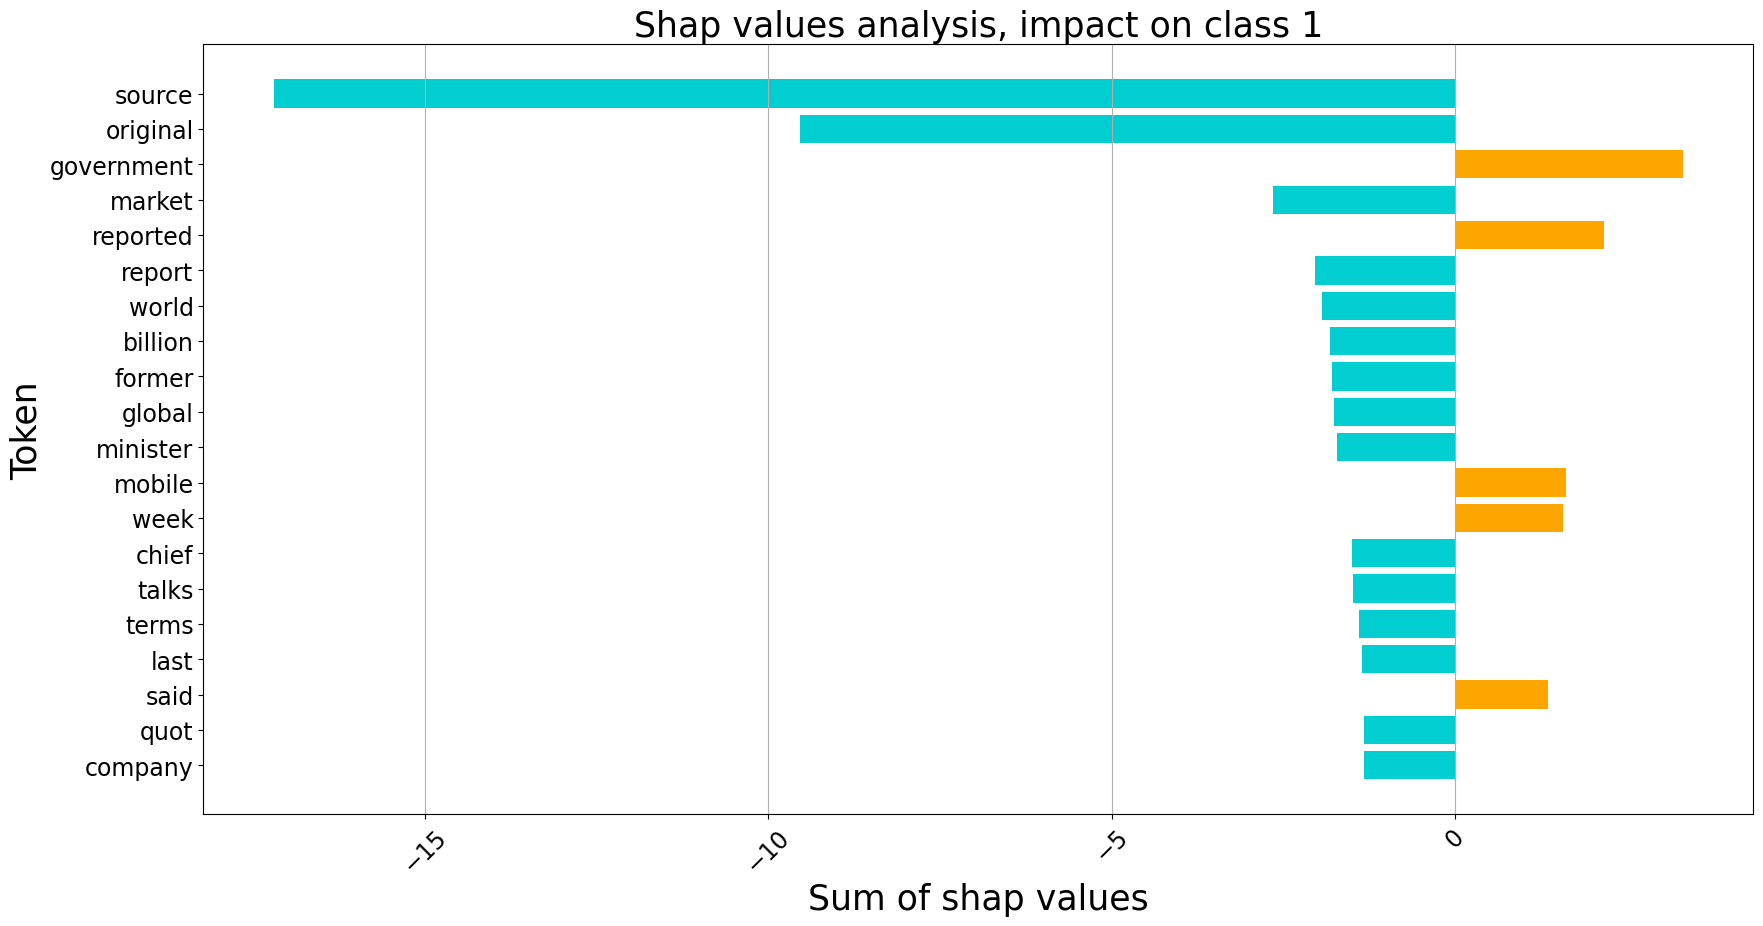

In [185]:
# IMPACT ON CLASS 1

plt.figure(figsize=(20,10))
plt.barh(range(len(to_plot_pos)), list(to_plot_pos.values()), tick_label=list(to_plot_pos.keys()), color = colors_list)
plt.xticks(fontsize=17, rotation = 45)
plt.yticks(fontsize=17)
plt.title('Shap values analysis, impact on class 1', fontsize = 25)
plt.ylabel('Token', fontsize = 25)
plt.xlabel('Sum of shap values', fontsize = 25)
plt.grid(axis = 'x')
plt.gca().invert_yaxis()
# plt.savefig('/home/cc/rora_tesi_new/log/log_TRC/twitter-roberta-large-2022-154m/bertweet-seq/20_epoch/data/True_weight/42_seed/shap/shap_pred_1.png',bbox_inches='tight')
plt.show()

In [2]:
# shap.plots.bar(shap_values_loaded[:,:,1].sum(0), order=shap.Explanation.argsort.flip)

In [21]:
# PLOT FOR CLASS 0

In [186]:
to_del = []
for k in sorted_d_neg.keys():
    if len(k) <= 3:
        to_del.append(k)
    if k == '....':
        to_del.append(k)

In [187]:
for k in to_del:
    del sorted_d_neg[k]

In [188]:
# remove_keywords(sorted_d_neg)

In [189]:
to_plot_neg = get_top_n(20, sorted_d_neg)

In [190]:
colors_list = colors(to_plot_neg)

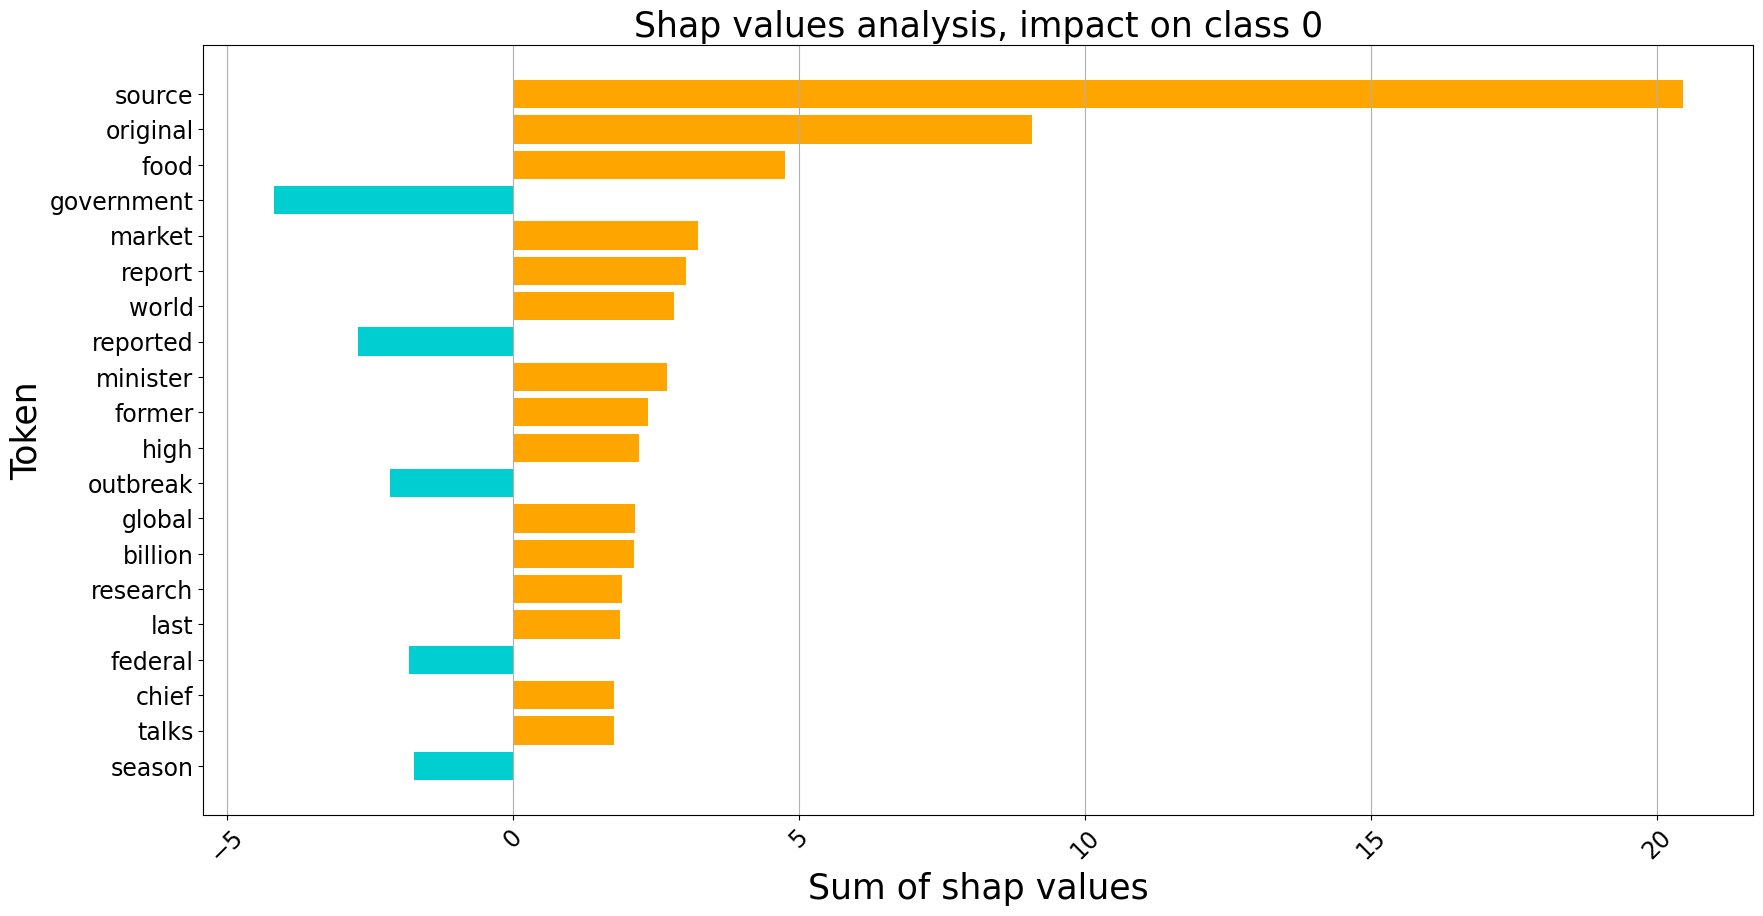

In [191]:
# IMPACT ON CLASS 0

plt.figure(figsize=(20,10))
plt.barh(range(len(to_plot_neg)), list(to_plot_neg.values()), tick_label=list(to_plot_neg.keys()), color = colors_list)
plt.xticks(fontsize=17, rotation = 45)
plt.yticks(fontsize=17)
plt.title('Shap values analysis, impact on class 0', fontsize = 25)
plt.ylabel('Token', fontsize = 25)
plt.xlabel('Sum of shap values', fontsize = 25)
plt.grid(axis = 'x')
plt.gca().invert_yaxis()
# plt.savefig('/home/cc/rora_tesi_new/log/log_TRC/twitter-roberta-large-2022-154m/bertweet-seq/20_epoch/data/True_weight/42_seed/shap/shap_pred_1.png',bbox_inches='tight')
plt.show()

In [1]:
# shap.plots.bar(shap_values_loaded[:,:,0].sum(0),  order=shap.Explanation.argsort.flip)